<h3><a href="https://pollytikhonova.github.io/bioinformatics_homeworks/Medicine_modelling"><img src="https://pollytikhonova.github.io/bioinformatics_homeworks/GitHub-Mark-32px.png" alt="Вернуться в репозиторий" title="Вернуться в репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a>
Tikhonova Polina. Homework 8. </h3>

In [153]:
from IPython.display import display,display_svg,SVG,Image, HTML,IFrame
import matplotlib.pyplot as plt
%matplotlib inline

### Составление файла et.top

In [ ]:
%%bash
cat /usr/share/gromacs/top/oplsaa.ff/atomtypes.atp

В предыдущей ячейке мы нашли нужные типы: opls_139, opls_140 (показано ниже)

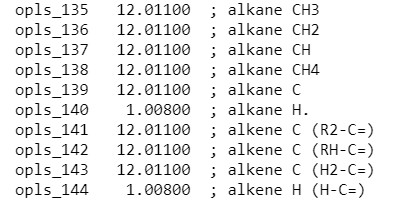

In [74]:
Image('alkane.png')

In [75]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from IPython.display import Image,display
import numpy as np

In [76]:
# создадим этан
mol=Chem.MolFromSmiles('CC')
AllChem.Compute2DCoords(mol)
m3d=Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(m3d)
AllChem.MMFFOptimizeMolecule(m3d,maxIters=500,nonBondedThresh=200 )

0

In [94]:
# связи
bonds_txt = []
bonds = m3d.GetBonds()
for i,b in enumerate(bonds):
    bonds_txt.append('{:>5}{:>5}{:>5}'.format(b.GetBeginAtomIdx()+1 , b.GetEndAtomIdx()+1,1))

# углы    
angles_txt = []
for i,b1 in enumerate(bonds):
    for b2 in list(bonds)[i:]:
        if (b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and b1.GetIdx() != b2.GetIdx()):
            angles_txt.append('{:>5}{:>5}{:>5}{:>5}'.format(b1.GetEndAtomIdx()+1 , b1.GetBeginAtomIdx()+1, b2.GetEndAtomIdx()+1,1))
        elif  b1.GetEndAtomIdx() == b2.GetBeginAtomIdx():
            angles_txt.append('{:>5}{:>5}{:>5}{:>5}'.format(b1.GetBeginAtomIdx()+1, b1.GetEndAtomIdx()+1, b2.GetEndAtomIdx()+1,1))

# dihedrals      
dihedrals_txt = []
for b1 in m3d.GetBonds():
    for b2 in m3d.GetBonds():
        for b3 in m3d.GetBonds():
             if b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and b1.GetIdx() != b2.GetIdx() and b2.GetEndAtomIdx() == b3.GetBeginAtomIdx():
                dihedrals_txt.append('{:>5}{:>5}{:>5}{:>5}{:>5}'.format(b1.GetEndAtomIdx()+1, b1.GetBeginAtomIdx()+1, b2.GetEndAtomIdx()+1, b3.GetEndAtomIdx()+1, 3))

In [95]:
part1 = '''
#include "/usr/share/gromacs/top/oplsaa.ff/forcefield.itp" 

[ moleculetype ]
; Name            nrexcl
et            3

[ atoms ]
;   nr  type  resnr  residue  atom   cgnr     charge       mass
    1   opls_139      1    ETH      C1      1    -0.189      12.01
    2   opls_139      1    ETH      C2      2    -0.155      12.01
    3   opls_140      1    ETH      H1      3     0.0059       1.008
    4   opls_140      1    ETH      H2      4     0.0059       1.008
    5   opls_140      1    ETH      H3      5     0.0059       1.008
    6   opls_140      1    ETH      H4      6     0.0056       1.008
    7   opls_140      1    ETH      H5      7     0.0056       1.008
    8   opls_140      1    ETH      H6      8     0.0056       1.008

[ bonds ]
;  ai    aj funct  b0       kb'''
part2 = '''
[ angles ]
;  ai    aj    ak funct  phi0   kphi'''
part3 = '''
[ dihedrals ]
;  ai    aj    ak    al funct'''
part4 = '''
[ pairs ]
; список атомов 1-4
;  ai    aj funct
   3  6
   3  7
   3  8
   4  6
   4  7
   4  8
   5  6
   5  7
   5  8

[ System ]
; any text here
first one
[ molecules ]
;Name count
 et    1'''

In [96]:
# записываем файл
parts_top_file = [part1]+bonds_txt+[part2]+angles_txt+[part3]+dihedrals_txt+[part4]
top_file = '\n'.join(parts_top_file)
with open('et.top', 'w') as f:
    f.write(top_file)

### Работа с 5ью методами

In [ ]:
%%bash
for s in be vr nh an sd
do
echo Work with $s method.
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/$s.mdp
grompp -f $s.mdp -c et.gro -p et.top -o et_$s.tpr
mdrun -deffnm et_$s -v -nt 1
trjconv -f et_$s.trr -s et_$s.tpr -o et_$s.pdb
g_energy -f et_$s.edr -o et_en_$s.xvg -xvg none
g_bond -f et_$s.trr -s et_$s.tpr -o bond_$s.xvg -n b.ndx -xvg none
done

### Aнализ

В зависимости от метода, в этане могут меняться как углы (иногда оочень сильно), так и длины связи.

In [174]:
IFrame(src="show_pdbs.html", width=900, height=890)

#### Энергии

Опять же, разные методы дают разительные результаты, кроме, пожалуй методов Velocity и стохастического.
Эти два метода дают довольно похожие картинки энергий, хотя поведение структур, которое мы могли наблюдать выше, при этих методах разное. 

Самую маленькую дисперсию имеет метод Андерсена, что, кстати говоря, отражается и в поведении структуры (она всего лишь немного дрыгается).

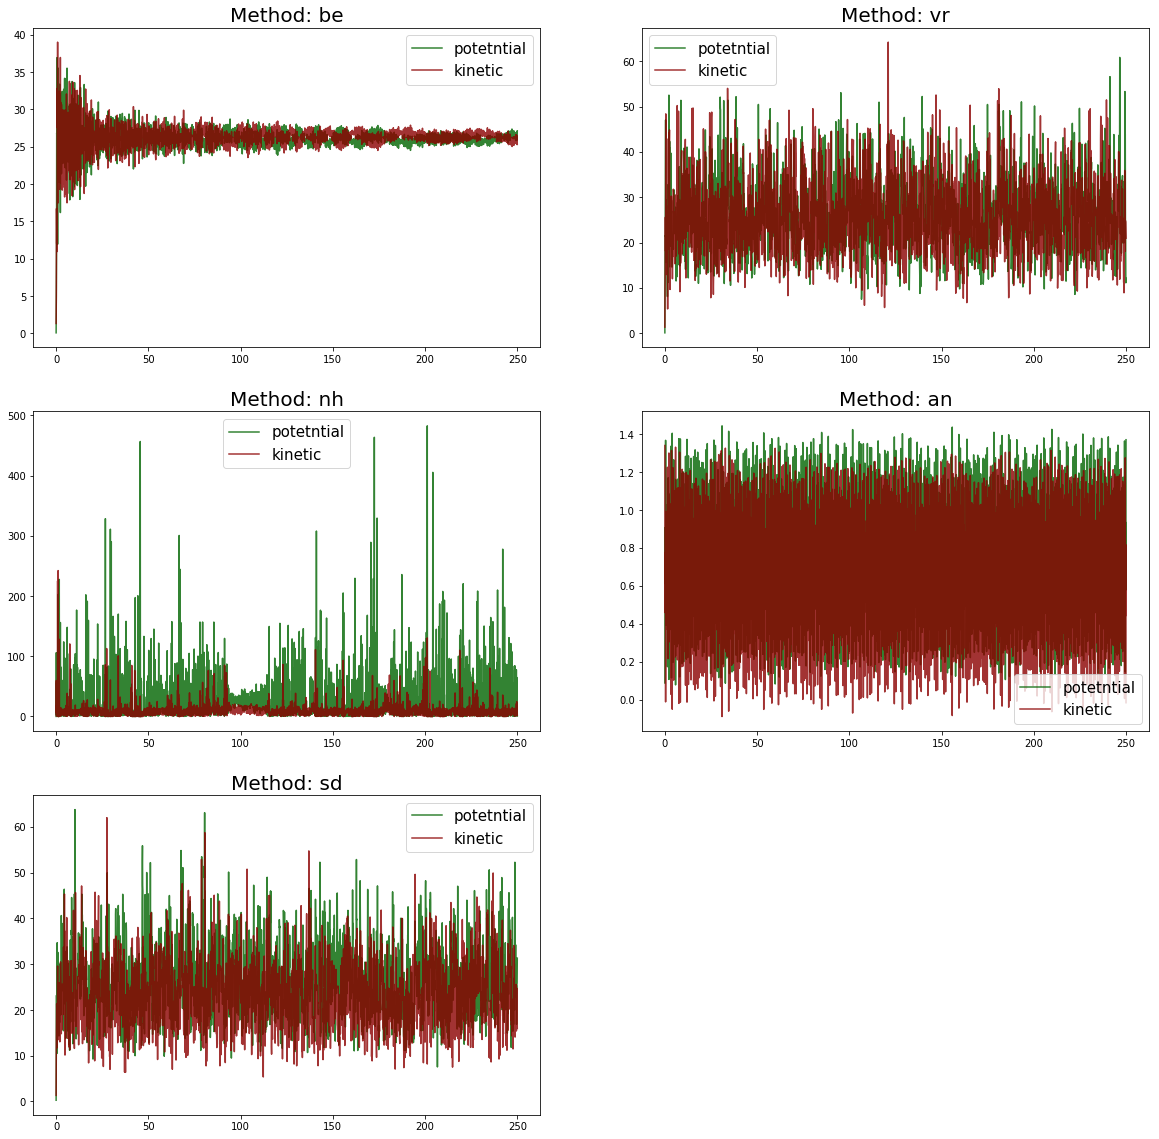

In [185]:
fig = plt.figure(figsize=(20,20))
for i, name in  enumerate(['be','vr','nh','an','sd']):
    fig.add_subplot(3,2,i+1)
    a= np.loadtxt('et_en_%s.xvg' % name)
    t=a[:,0]
    p=a[:,1]
    k=a[:,2]
    plt.plot(t,k, color='darkgreen', alpha = 0.8,label='potetntial')
    plt.plot(t,p, color='darkred',alpha = 0.8, label='kinetic')
    plt.legend( fontsize=15);
    plt.title('Method: %s'%name, fontsize=20)

#### Распределения длин связи С-С

Основной пик, практически у все совпадает (около 1.525 A), однако если верить векипедии, то длины связи должна быть около 1.54 А, и в таком случае наиболее близок стохастический метод.

Метод Андерсена в очередной раз демонстрирует очень низкую дисперсию (опять же, что мы и наблюдаем в визуализации).

А вот в методе Нуза-Хувера присутствует какой-то серьезный выброс, которого нет больше ни в одном распределении. 

Вообще разборс длин у остальных методов почти одинаковый.

Стоит также отметить, что методы Берендсена и Нуза-Хувера дают распределение, близкое к нормальному.

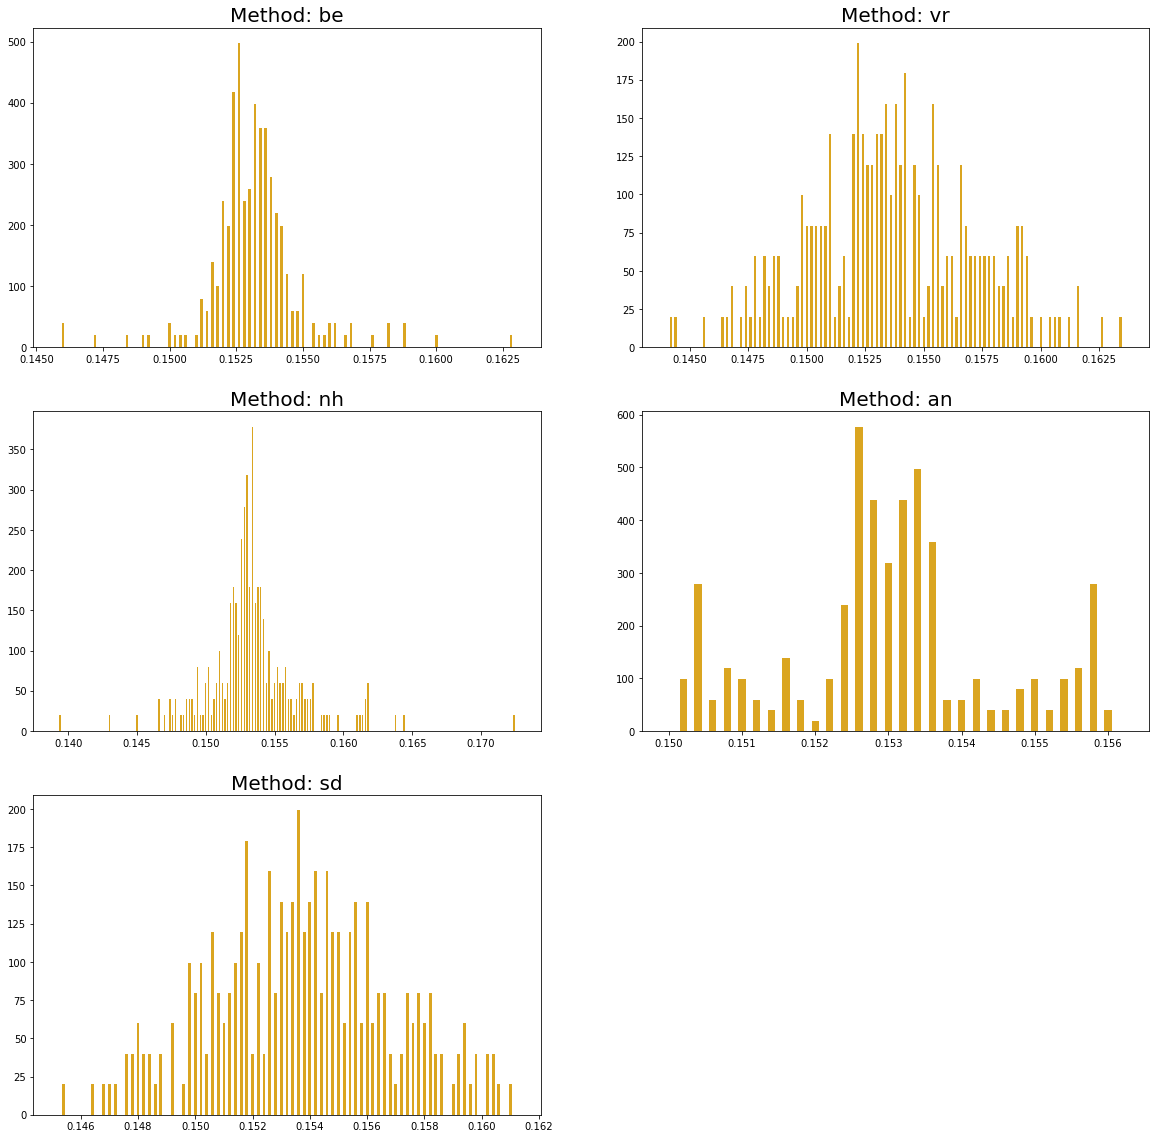

In [182]:
fig = plt.figure(figsize=(20,20))
for i, name in  enumerate(['be','vr','nh','an','sd']):
    fig.add_subplot(3,2,i+1)
    a= np.loadtxt('bond_%s.xvg' % name)
    t=a[:,0]
    p=a[:,1]
    plt.bar(t,p, 0.0001, color='goldenrod')
    plt.title('Method: %s'%name,  fontsize=20)

### Выводы

Таким образом, с учетом распределения Больцмана, наиболее правдивым можно считать метод Берендсена.
На графиках энергий этих методов мы наблюдаем затухающие колебания, что говорит о некой стабилизации системы. 
А еще, он почти самый быстрый...

||Node, s|Real, s|
|------|------|------|
|Be:    |2.890  |3.292  |
|Vr:    |3.090  |3.408  | 
|Nh:    |3.010  |3.284  | 
|An:    |3.010  |3.573  | 
|Sd:    |3.320 s|3.572  |

### Save to HTML

In [189]:
import subprocess
converted = subprocess.call(["jupyter-nbconvert", '--to', 'html',"Tikhonova. HW9.ipynb"], shell=False)
if converted==0:
    print 'Your ipynb-file was sucessfully converted!'
else:
    print 'Smth went wrong. for instance, check the filename...'
show_link = '<a href="%s" target="_blank">You can download it here!</a>'%('Tikhonova. HW9.html')
display(HTML(show_link))

Smth went wrong. for instance, check the filename...


#### <a href='Tikhonova. HW8.ipynb'> Download this notebook </a>